In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from evosax.algorithms import SV_CMA_ES as ES
from evosax.problems import BBOBProblem

In [2]:
key = jax.random.key(0)

num_dims = 2
# problem = BBOBProblem(fn_name="sphere", num_dims=num_dims, f_opt=0, seed=2)
problem = BBOBProblem(fn_name="rosenbrock", num_dims=num_dims, seed=2)
# problem = BBOBProblem(fn_name="rastrigin", num_dims=num_dims, seed=2)
# problem = BBOBProblem(fn_name="weierstrass", num_dims=num_dims, seed=2)

num_generations = 64

population_size = 32
# population_size = int(4 + jnp.floor(3 * jnp.log(num_dims)))

num_populations = 128

In [3]:
key, subkey = jax.random.split(key)
solution = problem.sample(subkey)
es = ES(
    population_size=population_size,
    num_populations=num_populations,
    solution=solution,
)

In [4]:
params = es.default_params

In [5]:
key, subkey = jax.random.split(key)
keys = jax.random.split(subkey, num_populations)
solutions = jax.vmap(problem.sample)(keys)

key, subkey = jax.random.split(key)
state = es.init(subkey, solutions, params)

In [6]:
key, key_ask = jax.random.split(key)
population, state = es.ask(key_ask, state, params)
population = jnp.clip(population, -5, 5)

In [7]:
key, key_eval = jax.random.split(key)
fitness, info = problem.eval(key_eval, population)

In [8]:
key, key_tell = jax.random.split(key)
state, metrics = es.tell(key_tell, population, fitness, state, params)

In [9]:
def step(carry, _):
    key, state, params = carry
    key, key_ask, key_eval, key_tell = jax.random.split(key, 4)
    population, state = es.ask(key_ask, state, params)
    population = jnp.clip(population, -5, 5)
    fitness, info = problem.eval(key_eval, population)
    state, metrics = es.tell(key_tell, population, fitness, state, params)
    return (key, state, params), (metrics,)

In [10]:
key, subkey = jax.random.split(key)
(key, state, params), (metrics,) = jax.lax.scan(
    step,
    (key, state, params),
    length=num_generations,
)

""

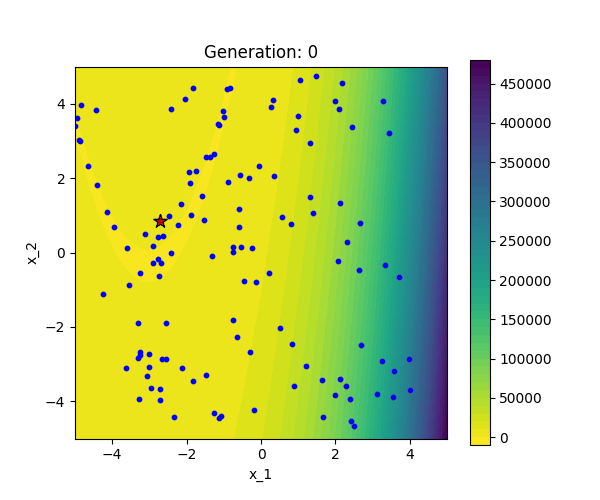

In [11]:
import matplotlib.animation as animation
import mediapy
from matplotlib.animation import PillowWriter

# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 5))

# Visualize the problem landscape
key, subkey = jax.random.split(key)
problem.visualize_2d(subkey, ax=ax)

# Extract mean trajectory from metrics
means = metrics["mean"]  # Shape: (num_generations, num_populations, num_dims)

# Create a scatter plot for all population means
scatter = ax.scatter([], [], color="blue", s=10)

# Add a title with generation counter
title = ax.set_title("Generation: 0")


def init():
    scatter.set_offsets(jnp.empty((0, 2)))
    return scatter, title


def update(frame):
    # Update the positions of all population means
    # means[frame] has shape (num_populations, num_dims)
    scatter.set_offsets(means[frame])

    # Update the title with current generation
    title.set_text(f"Generation: {frame}")

    return scatter, title


# Create the animation
anim = animation.FuncAnimation(
    fig, update, frames=len(means), init_func=init, blit=True
)

plt.close()

# Create a writer
path = "anim.gif"
anim.save(path, writer=PillowWriter())

# Display the GIF in the notebook
mediapy.show_video(mediapy.read_video(path), fps=20, codec="gif")